# EDSA - Climate Change Belief Analysis 2021




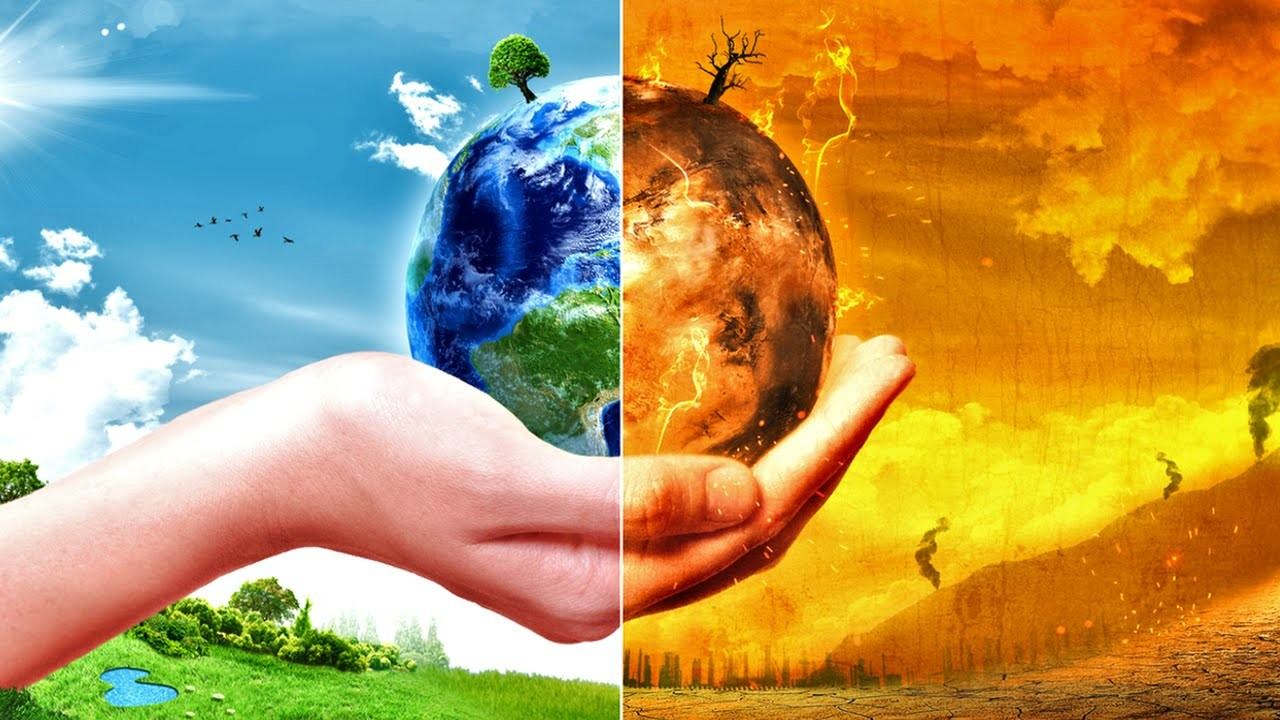

## By Team: Classification_MM2_DSF

### Dimakatso Mongwegelwa, Reitumetse Nchoe, Refiloe Dhlamini, Chantell Machobane, Emanuel Dikotla, Neo Sebanze

## Summary

Climate has been a big debate over the past decade, most companies build their products and services around reducing their impact on the enviroment. Understanding which beliefs your customers associate themselves with can be benfecial for companies ; ecspecially identifying which products and services to sell. In this notebook we attempt to display our process of EDA and model buidling related to user's tweets regarding climate chnage, in order to accurately determine whether a person belives in climate change. In the proccess we explored the dataset and gained insights that influenced which models we trained.

# Notebook Outline 

1. __Introduction__
2. __Installations__
    
    2.1 Packages
    
    2.2 Libraries 
3. __Loading Data__

    3.1 Viewing Data
    
4. __Data Cleaning__

    4.1 Clean text
    
    4.2 Tokenization, Stop words , Lemmatisation
    
5. __Data Visualisation__
    
    5.1 Fist Visualization (word cloud)
    
    5.2 Second Visualization (Bar charts)
    
6. __Model Building__
    
    6.1 Logistic Regression
    
    6.2 Multinomial Naive Bayes
    
    6.3 SVC (One-Vs-Rest)
    
7. __Model assesment ,selection and tuning__
8. __Model Testing__
9. __Storing Model__
10. __Classifying tweets__



## **1. Introduction**

Consumers have different beliefs and their buying patterns are influenced by those beliefs. In context with climate change, companies are affected in multiple ways. Besides the most obvious physical risks (for example, the operational impacts of extreme weather events, or supply shortages caused by water scarcity), companies are exposed to transition risks which arise from society’s response to climate change, such as changes in technologies, markets and regulation that can increase business costs and undermine the viability of existing products or services.  Another climate-related risk for companies is the potential liability for emitting greenhouse gases (GHG). An increasing number of legal cases have been brought directly against fossil fuel companies and utilities in recent years, holding them accountable for the damaging effects of climate change. 

It becomes beneficial for companies to correctly identify whether a customer believes in climate change as a result they know which product to sell. 
By analysing a customers tweet we can identify wich products to sell to them.
In this project we aim to accurately classify whether a person believs in climate change. this notebook details the work flow of team MM2 in designing and implementing a classification model and solution to climate change problem.

## **2. Installations**

## 2.1 Package Installation

In [ ]:
#!pip install comet_ml 

## 2.2 Importing Libraries 

In [ ]:
#from comet_ml import Experiment

In [ ]:
##Data Cleaning
from nltk.tokenize import word_tokenize, TreebankWordTokenizer
from nltk import SnowballStemmer, PorterStemmer, LancasterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import string 
import nltk 
import re
ps = nltk.PorterStemmer()

#model selection
from sklearn.model_selection import train_test_split

#classification model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix


# Visualisations
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud,ImageColorGenerator
from PIL import Image
import urllib
import requests
%matplotlib inline
sns.set()

#Metrics
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report, accuracy_score


# general
import numpy as np 
import pandas as pd 


## **3. Loading Data**

In [ ]:
df_train = pd.read_csv("../input/edsa-climate-change-belief-analysis-2021/train.csv")
df_test = pd.read_csv('../input/edsa-climate-change-belief-analysis-2021/test.csv')
df_sample = pd.read_csv('../input/edsa-climate-change-belief-analysis-2021/sample_submission.csv')

### 3.1 Viewing Data

In [ ]:
df_train.head()

In [ ]:
df_test.head()

In [ ]:
df_train.shape

In [ ]:
df_test.shape

The data for this competition is provided in two files df-train_set.csv and df-test_set.csv.The training set has 15819 rows and 3 columns while the the testing set has 10546 rows and 2 columns.

__columns__
- tweetid : Twitter unique id
- message : The tweet the user has posted
- sentiment : the class in which we are going to __classify__ our tweets 
 `2` (the tweet links to factual news about climate change)
 `1` (Pro: the tweet supports the belief of man-made climate change)
 `0` (Neutral: the tweet neither supports nor refutes the belief of man-made climate change)
 `-1` (Anti: the tweet does not believe in man-made climate change)

In [ ]:
#drop all duplicates in the training data
df_train.drop_duplicates(subset='message',inplace=True)
df_train.shape

we removed 1590 duplicates from our training data to avoid our model overfitting the subset point

# **4. Data Cleaning**

### Removing twitter handles `@`

In our analysis we can clearly see that the Twitter handles do not contribute anything significant to solve our problem. So it’s better if we remove them in our dataset. We create function to remove unwanted text patterns from the tweets. It takes two arguments, one is the original string of text and the other is the pattern of text that we want to remove from the string. The function returns the same input string but without the given pattern. We will use this function to remove the pattern ‘@user’ from all the tweets in our data.

In [ ]:
# function to remove the pattern ‘@user’ from all the tweets in our data.
def remove_pattern(text,pattern):
    
    # re.findall() finds the pattern i.e @user and puts it in a list for further task
    r = re.findall(pattern,text)
    
    # re.sub() removes @user from the sentences in the dataset
    for i in r:
        text = re.sub(i,"",text)
    
    return text

# Vectorization

df_train['message'] = np.vectorize(remove_pattern)(df_train['message'], "@[\w]*")
df_train.head()

### Function to clean data


This function removes short words, removes urls and replaces them with the word "url-web", converts the text to lowercase and removes all punctuation, numbers and special characters except the hashtags.

## 4.1 We are going to perform the following cleaning procedures to our data

- twitter handles : remove @usernames in the tweets

- short words : we remove words that have length less than 3 for example, terms like “hmm”, “and”, “oh” are of very little use. But we make an exception when it comes RT this term occurs frequently and it shows that the tweet has been retweeted (shared) so it has great significance.

- replace urls : URL's form part of noise in our data because it contains special characters , but in this context we can't remove it entirely cause it forms part of our sentiment, so in this case we need to replace it with the term "urlweb"

- remove all special characters excepet for "#" , the hash tag allows a tweet to reach a wider audience so in that sense it can make a good keyword.

- convert uppercases to lower

In [ ]:
def clean(df):
    
    #1.remove short words
    #if len(w)>1
    df['message'] = df['message'].apply(lambda x: ' '.join([w for w in x.split() ]))
    
    #2.remove url and replace with "url-web"
    pattern_url = r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+'
    subs_url = r'urlweb'
    df['message'] = df['message'].replace(to_replace = pattern_url, value = subs_url, regex = True)

    #3.Convert all uppercase to lower
    df['message'] = df['message'].str.lower()
    
    #4.punctuations , numbers and special characters excep #
    df['message'] = df['message'].str.replace("[^a-zA-Z#]", " ")
    
    return df

In [ ]:
clean(df_train)

### 4.2 __Tokenization, Stop words and Lemmatisation__

#### This is further data cleaning, from this part we structure the text to its bare minimum, getting rid of unwanted text such as stop words reducing words to thier `lemma` form.This process will be usefull when it comes to visualizing the data.

In [ ]:
#Tokenization
tokenized_tweet = df_train['message'].apply(lambda x: x.split())


#stop words
stopword = nltk.corpus.stopwords.words('english')

def remove_stopwords(text):
    text=[word for word in text if word not in stopword]
    return text
stop_words = tokenized_tweet.apply(lambda x: remove_stopwords(x))
stop_words.head()


#Lemmatisation
def train_lemma(words, lemmatizer):
    return [lemmatizer.lemmatize(word) for word in words]  

lemmatizer = WordNetLemmatizer()

df_lemma = stop_words.apply(train_lemma, args=(lemmatizer, ))

In [ ]:
# this is the final data set that we'll be using for our data visualization
df_lemma.head()

# __5. Data visualisation__

### 5.1 __First visualization :__ Wordclouds

In [ ]:
#we want to see how our labels looks
sum_value = df_train[['message','sentiment']].groupby('sentiment').count()

sum_value.sort_values('sentiment',ascending=False).plot(kind='bar')

Based on the graph we can see that majority of our data consist of `positive` sentiments (1 and 2) based on this visualization we can assume that which ever model we build it will be good at classifying sentiments that are 1 and 2

### 5.2 Generating wordclouds based on sentiments

Our second form of visualisation is going to be done by wordsclouds. They're going to show us the most/less frequent words that appear in our data set based on size.The most frequent words will be large and less frequent ones will be small.This will give us a better overall perspective on how our data looks.

We have categorized our tweets into those that are 
* anti-climate change `-1`
* neutral `0` 
* pro climate `1` and `2` change.


#### 5.2.1 __Generating wordcloud for tweets that are__ `anti-climate change`

In [ ]:
anti_climate = ' '.join(text for text in df_train['message'][df_train['sentiment']==-1])

In [ ]:
# combining the image with the dataset
Mask = np.array(Image.open(requests.get('http://clipart-library.com/image_gallery2/Twitter-PNG-Image.png', stream=True).raw))

# We use the ImageColorGenerator library from Wordcloud 
# Here we take the color of the image and impose it over our wordcloud
image_colors = ImageColorGenerator(Mask)

# Now we use the WordCloud function from the wordcloud library 
wc = WordCloud(background_color='black', height=1500, width=4000,mask=Mask).generate(anti_climate)

#### __Plot the `anti climate-change` word cloud__

In [ ]:
# Size of the image generated 
plt.figure(figsize=(10,20))

# Here we recolor the words from the dataset to the image's color
# recolor just recolors the default colors to the image's blue color
# interpolation is used to smooth the image generated 
plt.imshow(wc.recolor(color_func=image_colors),interpolation="hamming")

plt.axis('off')
plt.show()

Based on this visual we can see that the most occuring words are
* climate change
* global warming
* scam 
* man made 

This makes us come to the conclusion that most of the  people who believe that climate change/ global warming is man made or a scam.

#### 5.2.2 __Generating wordcloud for tweets that are__ `neutral climate-change`

In [ ]:
nuetral_climate = ' '.join(text for text in df_train['message'][df_train['sentiment']==0])

In [ ]:
wc = WordCloud(background_color='black', height=1500, width=4000,mask=Mask).generate(nuetral_climate)

#### __Plot the `nuetral climate-change` word cloud__

In [ ]:
# Size of the image generated 
plt.figure(figsize=(10,20))

# Here we recolor the words from the dataset to the image's color
# recolor just recolors the default colors to the image's blue color
# interpolation is used to smooth the image generated 
plt.imshow(wc.recolor(color_func=image_colors),interpolation="hamming")

plt.axis('off')
plt.show()

### 5.2.3 __Generating wordcloud for tweets that are__ `pro-climate change`

In [ ]:
pro_climate = ' '.join(text for text in df_train['message'][df_train['sentiment']>1])

In [ ]:
# Now we use the WordCloud function from the wordcloud library 
wc = WordCloud(background_color='black', height=1500, width=4000,mask=Mask).generate(pro_climate)

#### __Plot the `pro climate-change` word cloud__

In [ ]:
# Size of the image generated 
plt.figure(figsize=(10,20))

# Here we recolor the words from the dataset to the image's color
# recolor just recolors the default colors to the image's blue color
# interpolation is used to smooth the image generated 
plt.imshow(wc.recolor(color_func=image_colors),interpolation="hamming")

plt.axis('off')
plt.show()

Based on this visual we can see that the most occuring words are
* climate change
* url web : these are the websites that users have shared.
* Scientist and report 

we can see that people who mostly believe in cimate have some form of evidence to back up their claims as opposed to the anti-climate change believers who just dismiss climate change as hoax or a scam.

#### __Extracting the hashtags from the tweets__

In [ ]:
# We have create a function that extracts these hashtags from tweets
def Hashtags_Extract(x):
    hashtags=[]
    
    # Loop over the words in the tweet
    for i in x:
        ht = re.findall(r'#(\w+)',i)
        hashtags.append(ht)
    
    return hashtags

#### 5.3.1 __Anti climate change__

In [ ]:
anti_climate_change = Hashtags_Extract(df_train['message'][df_train['sentiment']==-1])

anti_climate_change_unnest = sum(anti_climate_change,[])


# Create word frequency
word_freq_anti_climate = nltk.FreqDist(anti_climate_change_unnest)

word_freq_anti_climate

#Create dataframe
df_anti_climate_change = pd.DataFrame({'Hashtags':list(word_freq_anti_climate.keys()),'Count':list(word_freq_anti_climate.values())})

df_anti_climate_change.head(5)

#### __Plot the data of the most used Hashtags__ `anti climate change`

In [ ]:
df_anti_climate_change_plot = df_anti_climate_change.nlargest(20,columns='Count') 

sns.barplot(data=df_anti_climate_change_plot,y='Hashtags',x='Count')
sns.despine()

#### 5.3.2 __Neutral to climate-change__

In [ ]:
neutral_climate_change = Hashtags_Extract(df_train['message'][df_train['sentiment']==0])
neutral_climate_change_unnest = sum(neutral_climate_change,[])

#Create word frequency
word_freq_neutral_climate = nltk.FreqDist(neutral_climate_change_unnest)

word_freq_neutral_climate

#Create dataframe
df_neutral_climate_change = pd.DataFrame({'Hashtags':list(word_freq_neutral_climate.keys()),'Count':list(word_freq_neutral_climate.values())})

df_neutral_climate_change.head(5)

#### __Plot the data of the most used Hashtags__ `nuetral climate change`

In [ ]:
df_neutral_climate_change_plot = df_neutral_climate_change.nlargest(18,columns='Count') 

sns.barplot(data=df_neutral_climate_change_plot,y='Hashtags',x='Count')
sns.despine()

#### 5.3.3 __Pro climate change__

In [ ]:
pro_climate_change = Hashtags_Extract(df_train['message'][df_train['sentiment']>=1])
pro_climate_change_unnest = sum(pro_climate_change, [])

#Create word frequency
word_freq_pro_climate = nltk.FreqDist(pro_climate_change_unnest)
word_freq_pro_climate

#Create dataframe
df_pro_climate_change = pd.DataFrame({'Hashtags':list(word_freq_pro_climate.keys()),'Count':list(word_freq_pro_climate.values())})

df_pro_climate_change.head(10)

#### __Plot the data of the most used Hashtags__ `pro climate change`

In [ ]:
df_pro_climate_change_plot = df_pro_climate_change.nlargest(20,columns='Count')

sns.barplot(data=df_pro_climate_change_plot,y='Hashtags',x='Count')
sns.despine()

#### 5.4 __Assesment from bargraphs__

We looked at the hashtags from both ends of the categories (-1 : 2)

Based on the data we can see that a lot of people  who don't believe in climate change have some form of political association with hashtags like #MAGA and #TRUMP frequently occuring. We also get to see that most of them believe that climate change is a product of fake news and is ultimatley a hoax or a scam.

People who believe in climate change tend to post about what's happening in the environment and changes in the climate that is occuring. Their belives are mostly rooted upon scinece as they provide some contnet of evidence.

## 6. __Model Building__

#### __Comet experiment__

create an experiment to track, compare, explain and optimize and our models.

In [ ]:
# experiment = Experiment(
#     api_key="4EuEqkOjsIwdXE8VWzNi6bLvx",
#     project_name="climate-change-classifier",
#     workspace="mm2-group",
# )

#### __Data split__
Performing split into train and test data. Test size will be 20% and have random state 42

In [ ]:
#We will be separating our dataset into features and labels
X = df_train['message'] #features
y = df_train['sentiment'] #labels

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

## 6.1 Logistic Regression

A logistic regression model predicts a dependent data variable by analyzing the relationship between one or more existing independent variables. It is used to predict a binary outcome based on a set of independent variables. A binary outcome is one where there are only two possible scenarios—either the event happens (1) or it does not happen (0). The purpose of logistic regression is to estimate the probabilities of events, including determining a relationship between features and the probabilities of particular outcomes.

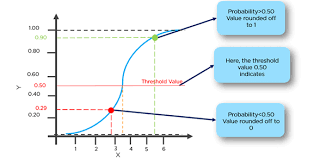

In [ ]:
#Appplying Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

lr = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', LogisticRegression(C = 10)),
              ])
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)

# Save  metric to add to a dictionary.
f1 = f1_score(y_test, y_pred,average='micro')
precision = precision_score(y_test, y_pred,average='macro')
recall = recall_score(y_test, y_pred,average='weighted')

#assesment
print(f"f1 score is : {f1}")
print("\n\nClassification Report:\n\n", classification_report(y_test, y_pred))

#### __Save metrics to `comet`__

In [ ]:
params = {
          "model_type": "Logistic Regression",
          #"param_grid": str(param_grid),
          }
metrics = {"f1": f1,
           "recall": recall,
           "precision": precision
           }

# experiment.log_parameters(params)
# experiment.log_metrics(metrics)

## 6.2 __Multinomial Naive Bayes__

Naive Bayes is a simple supervised machine learning algorithm that uses the Bayes’ theorem with strong independence assumptions between the features to procure results. That means that the algorithm just assumes that each input variable is independent. It really is a naive assumption to make about real-world data. For example, if you use Naive Bayes for sentiment analysis, given the sentence ‘I like Harry Potter’, the algorithm will look at the individual words and not the full sentence. In a sentence, words that stand next to each other influence the meaning of each other, and the position of words in a sentence is also important. However, for the algorithm, phrases like ‘I like Harry Potter’, Harry Potter like I’, and ‘Potter I like Harry’ are the same.

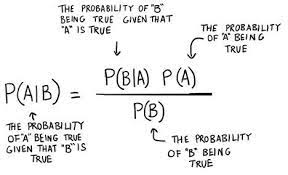

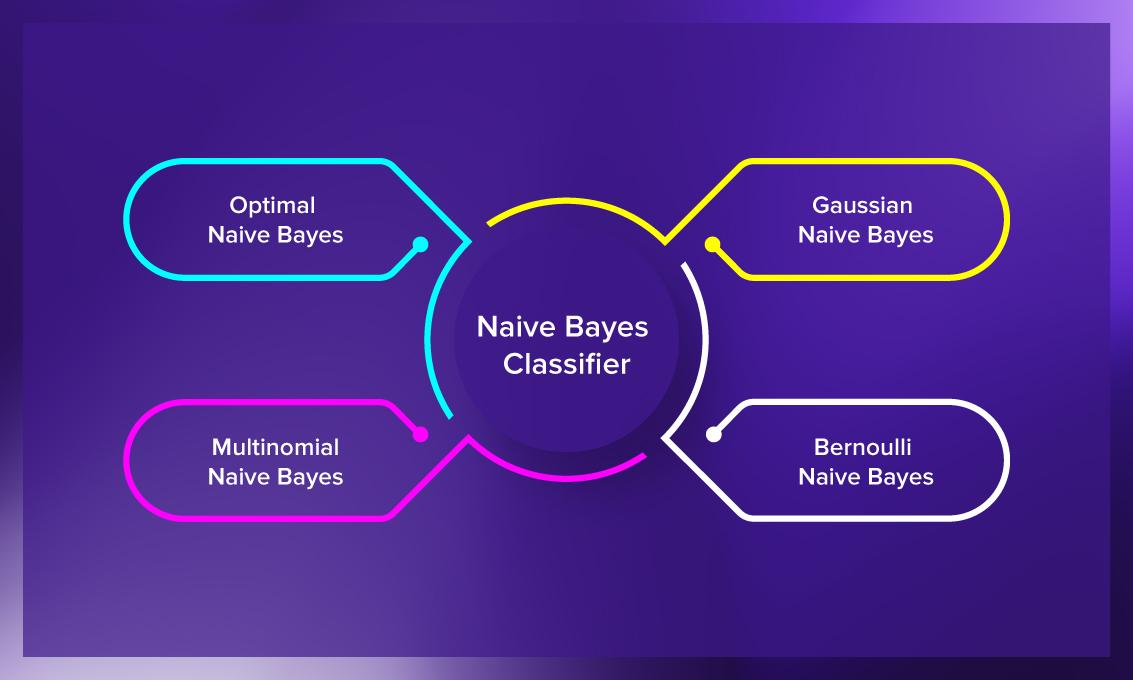


##### Multinomial Naive Bayes
It is usually applied to document classification problems. It bases its decisions on discrete features (integers), for example, on the frequency of the words present in the document.

In [ ]:
from sklearn.naive_bayes import MultinomialNB
mn = Pipeline([('vect', CountVectorizer(stop_words='english')),
               ('tfidf', TfidfTransformer()),
               ('clr', MultinomialNB()),
              ])
mn.fit(X_train,y_train)
y_pred = mn.predict(X_test)


# Save  metric to add to a dictionary.
f1 = f1_score(y_test, y_pred,average='micro')
precision = precision_score(y_test, y_pred,average='macro')
recall = recall_score(y_test, y_pred,average='weighted')

#assesment
print(f"f1 score is : {f1}")
print("\n\nClassification Report:\n\n", classification_report(y_test, y_pred))

#### __Save metrics to `comet`__

In [ ]:
params = {
          "model_type": "Multinomial Naive bayes",
          }
metrics = {"f1": f1,
           "recall": recall,
           "precision": precision
           }

# experiment.log_parameters(params)
# experiment.log_metrics(metrics)

### 6.3 __SVC (one vs rest classifier)__

One-vs.-rest strategy involves training a single classifier per class, with the samples of that class as positive samples and all other samples as negatives. This strategy requires the base classifiers to produce a real-valued confidence score for its decision, rather than just a class label; discrete class labels alone can lead to ambiguities, where multiple classes are predicted for a single sample

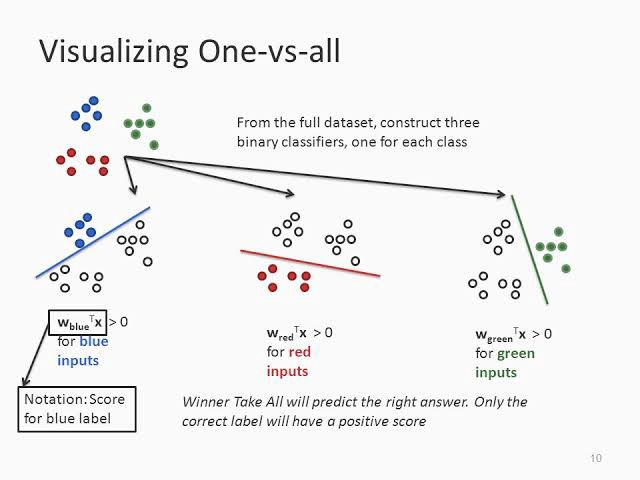

In [ ]:
from sklearn.svm import LinearSVC

In [ ]:
#applying one vs rest trough support vector classifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

ovr = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', OneVsRestClassifier(LinearSVC(C =5))),
              ])
ovr.fit(X_train,y_train)
y_pred = ovr.predict(X_test)


# Save  metric to add to a dictionary.
f1 = f1_score(y_test, y_pred,average='micro')
precision = precision_score(y_test, y_pred,average='macro')
recall = recall_score(y_test, y_pred,average='weighted')

#assesment
print(f"f1 score is : {f1}")
print("\n\nClassification Report:\n\n", classification_report(y_test, y_pred))

#### __Save metrics to `comet`__

In [ ]:
params = {
          "model_type": "OneVsRest ",
          }
metrics = {"f1": f1,
           "recall": recall,
           "precision": precision
           }

# experiment.log_parameters(params)
# experiment.log_metrics(metrics)

## 7.__Model assesment ,selection and tuning__

Based on the first two models we trained we got a f1-score Logistic Regression(__0.71__) and MultinomialNB(__0.62__),these scores are low relative to SVM(onevsrest) (__0.73__).The reason for the difference in output is how these models are structured, the logistic regression and multinomial NB are specificaly designed for `binary` classifications and that is not applicable to our scenario where we have `multiple`outputs instead of two.

With that being said  we decided to got for a`SVC` that uses a `one-vs-all` in oder to cater for our `multiOutput` dataset.We're to perform a grid-search where we try to find the optimal C value.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

In [ ]:
#running a grid search on our best model
params={'model__C':[.01,.05,.1,.5,1,5,10]}
pipeline = Pipeline([
    ('vect', CountVectorizer(min_df=40,ngram_range=(1,4))),
    ('tfidf', TfidfTransformer()),
    ('model',SVC())])
grid = GridSearchCV(pipeline, cv=5, n_jobs=-1, param_grid=params ,scoring='f1_weighted')

grid.fit(X_train, y_train)


In [ ]:
#get the best hyperparameter of C
grid.best_params_

#### __Save metrics to `comet`__

In [ ]:
params = {
          "model_type": "SVC",
          "param_grid": str(params),
          }
metrics = {"f1": f1,
           "recall": recall,
           "precision": precision
           }

# experiment.log_parameters(params)
# experiment.log_metrics(metrics)

### __View models from comet__

In [ ]:
# experiment.display()

In [ ]:
# #end the experiment
# experiment.end()

## 8. __Model Testing__

After trainig our model were going to test it on unseen data and see how it performs 

In [ ]:
# clean the test data with funtion
clean(df_test)

In [ ]:
X_unseen = df_test['message']

In [ ]:
tweet_id = df_test['tweetid']

In [ ]:
#make predictions with SVM(ovr) model
y_predict = ovr.predict(X_unseen)

In [ ]:
submission = pd.DataFrame(
    {'tweetid': tweet_id,
     'sentiment': y_predict
    })

In [ ]:
#submission.to_csv("Classification_MM2.csv",index=False)
submission.to_csv("submission.csv",index=False)

In [ ]:
submission.head()

## 9.__Storing Model__

In [ ]:
from sklearn import model_selection
import pickle

In [ ]:
pkl_file = "ovr.pkl"  

with open(pkl_file, 'wb') as file:  
    pickle.dump(ovr, file)

In [ ]:
# loading model
with open(pkl_file, 'rb') as file:  
    pickle_model = pickle.load(file)
    


## 10. __Classifying tweets__

In [ ]:
#we've created a tweet based on common key words from our hastags and  we  expect the model to give us a negative sentiment
user_tweet = 'climate change was man made'


In [ ]:
# making predictions on unseen test dataset
predictions = pickle_model.predict([user_tweet])
predictions